<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/Flow_of_Latent_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

layer initialization seed setting

https://keras.io/api/layers/core_layers/dense/
- kernel_initializer="glorot_uniform",
- bias_initializer="zeros",


Additional Seed setting for weight initialization!!

- kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)


Summary of Seed Setting
1. original model: seed=42 for all layers
2. Transfer Learning : seed= 2*seed for adjustable layers

3. 10 trials mean:
- Original model: seed=random for all layer
- Transfer learning:  seed=random for adjustable layers

# 1. Setting

#### 1-1. Figure

In [1]:
import os
outdir = './fig'
os.makedirs(outdir, exist_ok=True)

SAVE_SPLIT = True
SHOW_CAPTION = True


#### 1-2. Terminology

In [2]:
from dataclasses import dataclass
@dataclass
class Notation:
    y1: str = "K-Intensive"
    y2: str = "Inverted K-Intensive"
    y3: str = "L-Intensive"

note = Notation()

#### 1-3. Model

In [3]:
# Structure of hidden layers
nodes = (8, 8, 8, 4)
act_fc = 'relu' # 'linear'

# epochs
org_ep = 100
tl_ep = 30

# random seed
SEED=41


# data generation
n = 1000
noise_scale = 0.05

# 2. Preparation

#### 2-1. Visualization

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import count
import numpy as np
import re
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda


# === 1. Data ===

np.random.seed(SEED)
tf.random.set_seed(SEED)
rng = np.random.default_rng(SEED)

Fixed_Dense = lambda n, activation: Dense(
    n, activation = activation,
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
)


In [5]:
FIG_NO = count(1)

def _expand_title(title_prefix: str) -> str:
    # extract inside <> or []
    m = re.search(r'[\[<]\s*(.*?)\s*[\]>]', title_prefix or "")
    core = (m.group(1) if m else title_prefix or "").strip()

    # try to parse "TL A + B → T"
    m2 = re.match(r'^TL\s+(.+?)\s*\+\s*(.+?)\s*→\s*(.+)$', core)
    if not m2: # remove brackets and return
      return core
    A, B, T = [s.strip() for s in m2.groups()]
    return f"{A} transfer learned with {B}" + " to predict {T}" if T != B else ""

def _set_label(ax, axif, y_lim=None):
    if SHOW_CAPTION:
      ax.set_title(axif['title'])
    ax.set_xlabel(axif['x']); ax.set_ylabel(axif['y']);
    if axif['z']:
       ax.set_zlabel(axif['z']);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    if y_lim is not None:
        ax.set_zlim(*y_lim)

def _savefig(path, ax=None):
    (ax if ax is not None else plt).savefig(path, dpi=250, bbox_inches="tight")


def draw_triptych(title_prefix, Kv, Lv, y_true, y_pred,
                  fig_no=1, caption=None, y_lim=None, show=True, folder=''):

    mse = (y_true - y_pred) ** 2
    cmap_y = "Greys"
    m_true, m_pred = "o", "^"
    edge = "black"
    ax_info = {
        'a_true': dict(title="(a) True Y", x='K', y='L', z='Ŷ',
                      ydata=y_true, proj='3d', mk=m_true, ),
        'b_pred': dict(title="(b) Predicted Ŷ", x='K', y='L', z='Ŷ',
                      ydata=y_pred, proj='3d', mk=m_pred),
        'c_mse': dict(title="(c) MSE (Y−Ŷ)^2\n", x='', y="\n\n\n\nMSE", z='',
                      ydata=y_pred, proj=None, mk='s'),
        }

    fig = plt.figure(figsize=(10, 4))
    gs = GridSpec(nrows=1, ncols=3, figure=fig, width_ratios=[1, 1, 1])

    # (a) True — 3D
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    ax1.scatter(Kv, Lv, y_true, c=y_true, cmap=cmap_y,
                alpha=0.8, s=14, marker=m_true, edgecolor=edge, linewidth=0.3)
    _set_label(ax1, ax_info['a_true'], y_lim)

    # (b) Predicted — 3D
    ax2 = fig.add_subplot(gs[0, 1], projection='3d')
    ax2.scatter(Kv, Lv, y_pred, c=y_pred, cmap=cmap_y,
                alpha=0.8, s=14, marker=m_pred, edgecolor=edge, linewidth=0.3)
    _set_label(ax2, ax_info['b_pred'], y_lim)


    # (c) MSE — 2D: x = varying axis (K or L), y = MSE
    ax3 = fig.add_subplot(gs[0, 2])
    axif = ax_info['c_mse']
    x_vals, x_label = np.ravel(Kv), "K"
    if np.nanstd(Kv) < 1e-9:
        x_vals, x_label = np.ravel(Lv), "L"
    axif['x'] = x_label
    ax3.scatter(x_vals, np.ravel(mse), c="dimgray", s=12,
                marker="s", edgecolor=edge, linewidth=0.3)
    _set_label(ax3, axif)

    if SHOW_CAPTION:
      fig_no = next(FIG_NO)
      pretty = _expand_title(title_prefix)
      cap = f"Figure {fig_no}. {pretty}"
      if caption:
          cap += f" — {caption}"
      fig.suptitle(cap, fontsize=18, y=0.9)

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, bottom=0.05, wspace=0.35)
    ax1.text2D(0.02, 0.92, "○ True,  △ Pred,  ■ MSE",
               transform=ax1.transAxes, fontsize=9)

    if show:
      plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
      plt.show()

    if not SAVE_SPLIT or not folder:
      return

    title_prefix = folder
    os.makedirs(f'{outdir}/{title_prefix}', exist_ok=True)

    for lab, axif in ax_info.items():
        sub_fig = plt.figure(figsize=(4, 4))
        new_ax = sub_fig.add_subplot(111, projection=axif['proj'])
        _set_label(new_ax, axif)

        XVAL, YVAL = (Kv, Lv) if axif['proj'] else (x_vals, np.ravel(mse))
        if axif['proj']:
          new_ax.set_zlabel(axif['z'])
          new_ax.scatter(XVAL, YVAL, axif['ydata'], c=axif['ydata'], cmap=cmap_y,
                        alpha=0.8, s=14, marker=axif['mk'], edgecolor=edge, linewidth=0.3)
          if y_lim is not None:
            new_ax.set_zlim(*y_lim)
        else:
          new_ax.scatter(XVAL, YVAL, c="dimgray", s=12, marker="s", edgecolor=edge, linewidth=0.3)

        _savefig(f"{outdir}/{title_prefix}/{lab}.png", sub_fig)
        plt.close(sub_fig)



### 2-2. Data Generation

In [6]:
# K-intensive: K~U(0,1), L=0
K = np.random.rand(n, 1)
L0 = np.zeros((n, 1))
X_K = np.hstack([K, L0])

# L-intensive: K=0, L~U(0,1)
K0 = np.zeros((n, 1))
L = np.random.rand(n, 1)
X_L = np.hstack([K0, L])

# Targets with noise
y1 = K**3 + np.random.normal(0, noise_scale, size=(n, 1))      # K³ + noise
y2 = -K**3 + np.random.normal(0, noise_scale, size=(n, 1))     # −K³ + noise
y3 = L**3 + np.random.normal(0, noise_scale, size=(n, 1))      # L³ + noise
y4 = -L**3 + np.random.normal(0, noise_scale, size=(n, 1))


# 3. Build & Train Model

### 3-1. Build Original Model

In [7]:
def build_model(fixed=True):
  global nodes, act_fc
  d = Fixed_Dense if fixed else Dense
  m = Sequential([
      tf.keras.Input(shape=(2,)),
      *[d(nodes[i], activation=act_fc) for i in range(len(nodes))],
      d(1, activation="linear")
  ])
  m.compile(optimizer="adam", loss="mse")
  return m

model = build_model()
model.fit(X_K, y1, epochs=org_ep, batch_size=32, verbose=0)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 629 (2.46 KB)

 Trainable params: 209 (836.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 420 (1.64 KB)

In [8]:
def run_prediction(m_y2, m_y3, title, fig_no=1, caption=['', '', ''], isTL=False):
    global FIG_NO, model
    y1_pred = model.predict(X_K, verbose=0)
    y2_pred = m_y2.predict(X_K, verbose=0)
    y3_pred = m_y3.predict(X_L, verbose=0)
    FIG_NO = count(fig_no)
    t = f'{title}\n{note.y1} '
    if isTL:
      draw_triptych(f"{t}→ {note.y1}", K, L0, y1, y1_pred,
                    folder=f'origin_{note.y1}_{note.y1}')
      draw_triptych(f"{t}+ {note.y2} → {note.y2}{': '+caption[0]}", K, L0,  y2, y2_pred, y_lim = (-1,0),
                    folder=f'trasferlearn_{note.y1}_{note.y2}')
      draw_triptych(f"{t}+ {note.y3} → {note.y3}{': '+caption[2]}", K0, L, y3, y3_pred, y_lim = (0,1),
                    folder=f'trasferlearn_{note.y1}_{note.y3}')
    else:
      draw_triptych(f"{t}→ {note.y1}", K, L0, y1, y1_pred,
                    folder=f'origin_{note.y1}_{note.y1}')
      draw_triptych(f"{t}→ {note.y2}", K, L0, y2, y2_pred,
                    folder=f'origin_{note.y2}_{note.y2}')
      draw_triptych(f"{t}→ {note.y3}", K0, L, y3, y3_pred, y_lim=(0, 1),
                    folder=f'origin_{note.y3}_{note.y3}')

### 3-2. Run

#### 3-2-1 Original Model

Evaluated on untrained data - high MSE

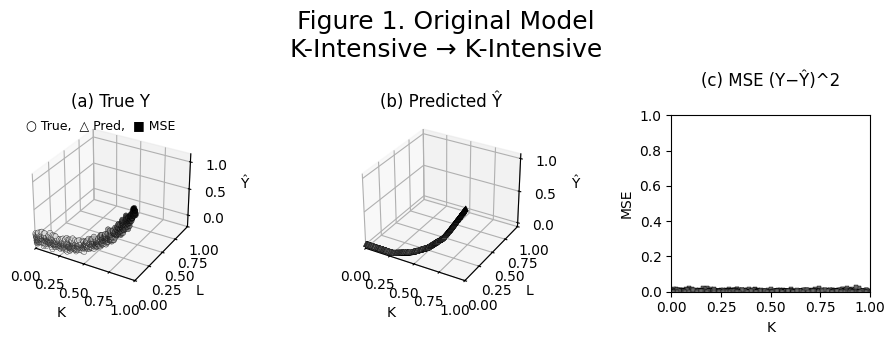

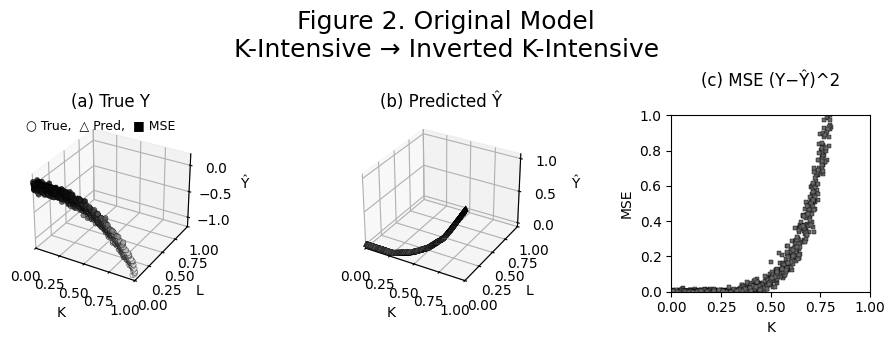

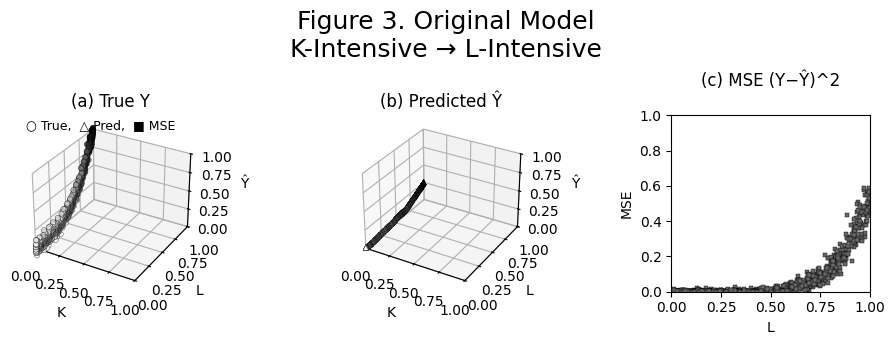

In [ ]:
run_prediction(
    model, model, "Original Model",
    fig_no=1, isTL=False,
    caption=['Good fit', 'Poor fit', 'Poor fit']
)

#### 3-2-2  Transfer Learning

 with 1 or 2 trainable layers

In [9]:
def build_tl_model_flexible(trainable=1, seed=SEED):
    global model
    m = tf.keras.Sequential()
    N = len(model.layers) - trainable
    for i, lyr in enumerate(model.layers):
        lyr.trainable=False
        m.add(lyr if i<N else
            Dense(lyr.weights[0].shape[-1], activation=lyr.activation,
                kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed*2)
              ))

    m.compile(optimizer="adam", loss="mse")
    return m

def build_tl_y2_y3(epochs, trainable=1):
    m_y2 = build_tl_model_flexible(trainable=trainable)
    m_y2.fit(X_K, y2, epochs=epochs, batch_size=32, verbose=0)
    m_y3 = build_tl_model_flexible(trainable=trainable)
    m_y3.fit(X_L, y3, epochs=epochs, batch_size=32, verbose=0)

    for l2, l3 in zip(m_y2.layers, m_y3.layers):
        print(f"{l2.name:25s} tr={l2.trainable}   {l3.name:25s} tr={l3.trainable}")
    return m_y2, m_y3

dense                     tr=False   dense                     tr=False
dense_1                   tr=False   dense_1                   tr=False
dense_2                   tr=False   dense_2                   tr=False
dense_5                   tr=True   dense_7                   tr=True
dense_6                   tr=True   dense_8                   tr=True


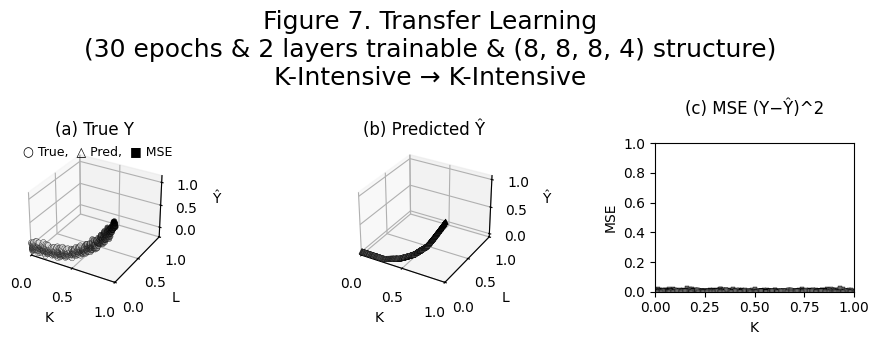

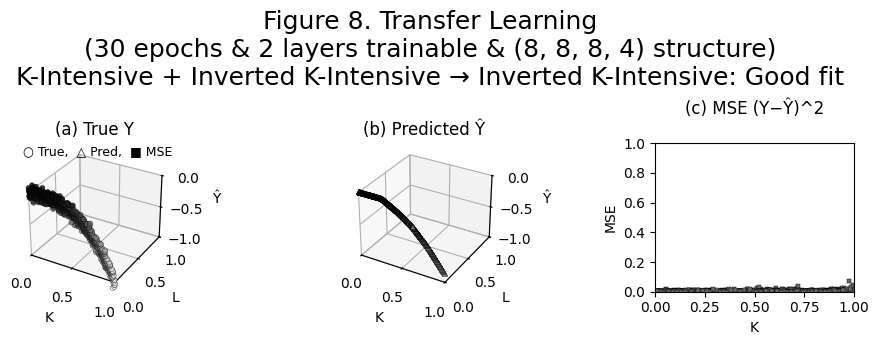

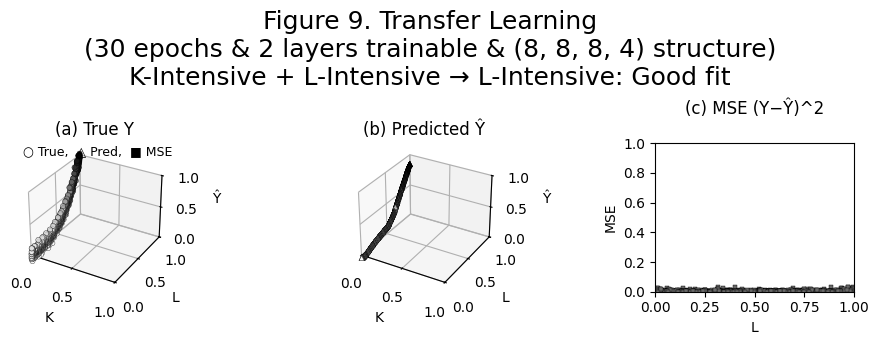

In [10]:
model_tf_2layer_y2, model_tf_2layer_y3 = build_tl_y2_y3(tl_ep, trainable=2)

run_prediction(
    model_tf_2layer_y2, model_tf_2layer_y3,
    title=f'Transfer Learning\n({tl_ep} epochs & 2 layers trainable & {nodes} structure)',
    fig_no=7, isTL=True, caption=['Good fit']*3
)

dense                     tr=False   dense                     tr=False
dense_1                   tr=False   dense_1                   tr=False
dense_2                   tr=False   dense_2                   tr=False
dense_3                   tr=False   dense_3                   tr=False
dense_9                   tr=True   dense_10                  tr=True


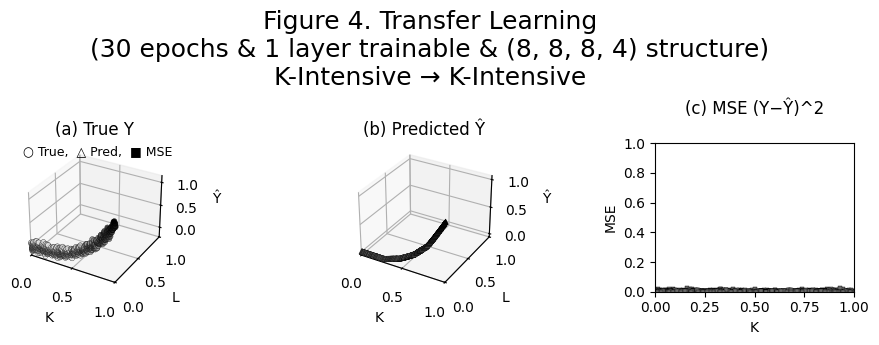

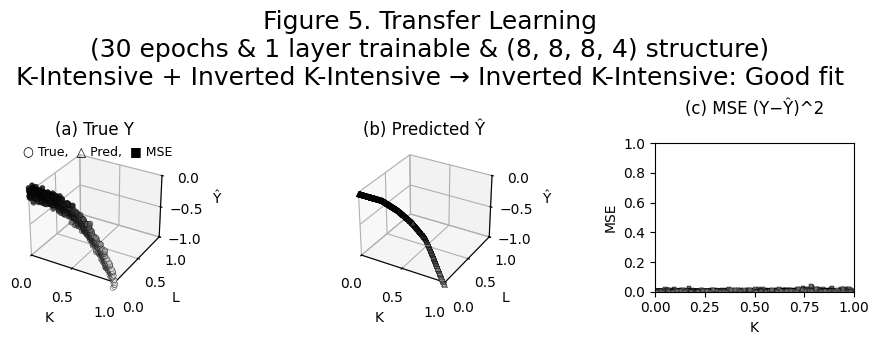

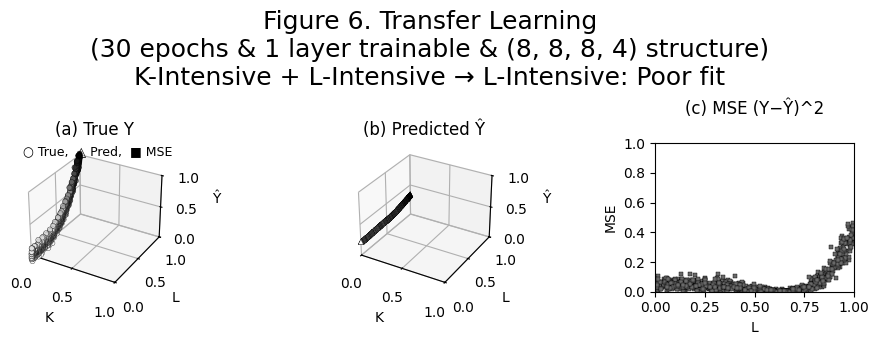

In [11]:
model_tf_1layer_y2, model_tf_1layer_y3 = build_tl_y2_y3(tl_ep, trainable=1)

run_prediction(
    model_tf_1layer_y2, model_tf_1layer_y3,
    title=f'Transfer Learning\n({tl_ep} epochs & 1 layer trainable & {nodes} structure)',
    fig_no=4, isTL=True, caption=['Good fit']*2 +['Poor fit']
)

# 4. Latent Features

In [12]:
np.array([0.1*1, 2], dtype=np.float32) @ np.ones((2,8))

array([2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1])

### 4-1. Library

In [13]:
import matplotlib.style as style

style.use('tableau-colorblind10')


def get_relu_keep_probs_aligned(model, X_batch):
    X = tf.identity(X_batch)
    masks, layer_indices = [], []

    for idx, layer in enumerate(model.layers):
        ws = layer.get_weights()
        if len(ws) == 0:
            try: # no weights -> forward propagate to update X for subsequent layers
                X = layer(X)
            except Exception:
                # fallback: if layer defines 'activation' wrapper, apply it; else skip
                act = getattr(layer, "activation", None)
                if act is not None:
                    X = act(X)
            continue

        X = tf.cast(X, np.float32)
        W_tf = tf.convert_to_tensor(ws[0], dtype=np.float32)
        z = tf.matmul(X, W_tf) # pre-activation z = X @ W + b (if present)
        if len(ws) > 1:
            b_tf = tf.convert_to_tensor(ws[1], dtype=np.float32)
            z = z + b_tf  # broadcast

        act = getattr(layer, "activation", None)
        masks.append(
            tf.reduce_mean(tf.cast(z > 0.0, np.float32), axis=0).numpy()
            if (act == tf.keras.activations.relu) else None)
        layer_indices.append(idx)

        try: # propagate X using the actual layer (so next z computed correctly)
            X = layer(X)
        except Exception:
            X = act(z) if act is not None else z
    return masks, layer_indices

def compute_forward_path(
     Ws, Bs, dense_layer_indices,other_val, layer_idxs,
     masks, include_bias=False, switchKL=False
):
    N = 11
    kpath = []
    for ktrial in range(N):
      if switchKL:
        e = np.array([float(other_val), 0.1*ktrial], dtype=np.float32)
      else:
        e = np.array([0.1*ktrial, float(other_val)], dtype=np.float32)
      path, v = [e.copy()], None
      for k, W in enumerate(Ws):
          if v is None: # first weight-layer: contribution e @ W
              v = e @ W  # shape (out_dim,)
          else: # find mask position for prev_layer_idx in dense_layer_indices
            if masks[dense_layer_indices.index(layer_idxs[k-1])] is not None:
              v = np.where(v > 0.0, v, 0)
            v = v @ W # propagate to next layer
          if include_bias and Bs[k] is not None:
              v = v + Bs[k]
          path.append(v.copy())
      kpath.append(path.copy())

    return kpath

def layer_stats(path):
    layer_L1 = [np.sum(np.abs(x)) for x in path]
    total = sum(layer_L1) if sum(layer_L1) != 0 else 1.0
    layer_pct = [x / total for x in layer_L1]
    layer_units = [x.shape[0] for x in path]
    return layer_L1, layer_pct, layer_units


def feature_path(_model, X_batch, other_val, include_bias=True, switchKL=False):
    print(other_val)
    masks, dense_layer_indices = get_relu_keep_probs_aligned(_model, X_batch)
    Ws, Bs, layer_idxs = [], [], []
    for idx, layer in enumerate(_model.layers):
        ws = layer.get_weights()
        if len(ws) == 0: continue;
        Ws.append(ws[0].astype(np.float32))
        Bs.append((ws[1].astype(np.float32) if (include_bias and len(ws) > 1) else None))
        layer_idxs.append(idx)

    if len(Ws) == 0:
        raise ValueError("Model has no weight-containing layers.")

    kpaths = compute_forward_path(
        Ws, Bs, dense_layer_indices, other_val,
        layer_idxs, masks, include_bias, switchKL)

    # layer_L1, layer_pct, layer_units = layer_stats(path)
    return {
        "paths": kpaths,
        "layer_idxs": layer_idxs, "masks": masks,
        "dense_layer_indices": dense_layer_indices
    }


In [14]:
marker = ["x", "."]
order_ = ['Input', *[f'Hidden {i}' for i in range(1, len(nodes)+1)], 'Output']

input_str = lambda kl, t, f: f"{'L' if kl else 'K'}={f[t][0][kl-0]:.2f}"

def _plot_value(ax, h, v):
    ax.text(0, h, f"{v:.2f}", ha="center", va="center", size=12, color='white' if v<=0 else 'black')

def plot_feature_path(
    model, X_batch, vmin=-1, vmax=1,
    cmap='gray', caption='', switchKL=False,
    folder='latent_feature', filename='gradual_vectors', other_val=0
):
    feat_vecs = feature_path(model, X_batch, other_val, switchKL=switchKL)['paths']
    rows, cols = len(feat_vecs), len(feat_vecs[0])
    layer_titles = [
        f"{order_[k]}\n(# = {feat_vecs[0][k].shape[0]})\n"
        for k in range(cols)]
    print(rows, cols)

    temp = feat_vecs[1::3].copy()
    fig, axes = plt.subplots(len(temp), cols, figsize=(cols+1, len(temp)*2))
    for k in range(cols):
      axes[0][k].set_title(layer_titles[k], fontsize=12)
    for t in range(len(temp)):
      axes[t][0].set_ylabel(input_str(switchKL, t, temp), fontsize=12)
      _plot_value(axes[t][0], 0, temp[t][0][0])
      _plot_value(axes[t][0], 1, temp[t][0][1])
      for k, v in enumerate(temp[t]):
          ax = axes[t][k]; ax.set_yticks([]); ax.set_xticks([]);
          ax.imshow(v[np.newaxis, :].T, aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)
      _plot_value(axes[t][-1], 0, v[0])

    cbar = fig.colorbar(
        plt.cm.ScalarMappable(
          norm=plt.cm.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap),
          ax=axes.ravel().tolist(), orientation='vertical', fraction=0.12, pad=0.02, aspect=20)
    cbar.set_label("Value")
    if SAVE_SPLIT:
      os.makedirs(f"{outdir}/{folder}", exist_ok=True)
      _savefig(f"{outdir}/{folder}/{filename}.png")
    else:
      plt.show()


### 4-2. Forward Propagation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


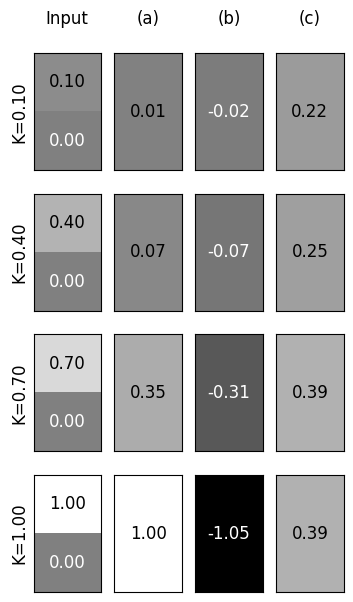

In [15]:
results = [
    [ m.predict(np.array([k*0.1, 0.]).reshape(-1,2))[0] for k in range(1,15,3) ]
    for m in [model, model_tf_1layer_y2, model_tf_1layer_y3]
]

fig, axes = plt.subplots(4,4, figsize=(4, 7))
for k in range(4):
  axes[0][k].set_title(['Input', '(a)', '(b)', '(c)'][k]+'\n', fontsize=12)

for i in range(4):
    axes[i][0].set_ylabel(f'K={(i+1)*0.3-0.2:.2f}', fontsize=12)
    ax = axes[i][0]; ax.set_yticks([]); ax.set_xticks([]);
    ax.imshow(np.array([(i+1)*0.3-0.2, 0.]).reshape(2,-1), aspect='auto', vmin=-1, vmax=1, cmap='gray')
    _plot_value(axes[i][0], 0, (i+1)*0.3-0.2)
    _plot_value(axes[i][0], 1, 0)

for k in range(1, 4):
  for i in range(4):
      ax = axes[i][k]; ax.set_yticks([]); ax.set_xticks([]);
      ax.imshow(results[k-1][i][np.newaxis, :].T, aspect='auto', vmin=-1, vmax=1, cmap='gray')
      _plot_value(axes[i][k], 0, results[k-1][i][0])


if SAVE_SPLIT:
  folder='latent_feature'
  filename='only_output_kvar'
  os.makedirs(f"{outdir}/{folder}", exist_ok=True)
  _savefig(f"{outdir}/{folder}/{filename}.png")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


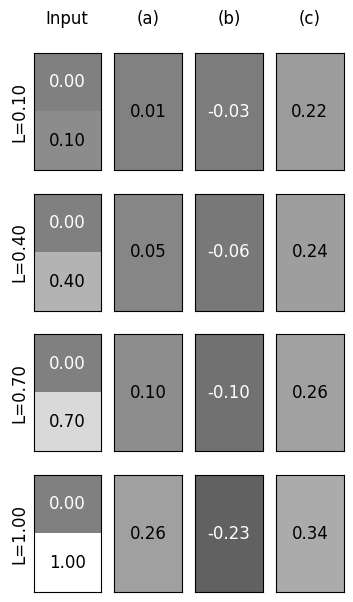

In [ ]:
results = [
    [ m.predict(np.array([0., k*0.1]).reshape(-1,2))[0] for k in range(1,15,3) ]
    for m in [model, model_tf_1layer_y2, model_tf_1layer_y3]
]

fig, axes = plt.subplots(4,4, figsize=(4, 7))
for k in range(4):
  axes[0][k].set_title(['Input', '(a)', '(b)', '(c)'][k]+'\n', fontsize=12)

for i in range(4):
    axes[i][0].set_ylabel(f'L={(i+1)*0.3-0.2:.2f}', fontsize=12)
    ax = axes[i][0]; ax.set_yticks([]); ax.set_xticks([]);
    ax.imshow(np.array([0., (i+1)*0.3-0.2]).reshape(2,-1), aspect='auto', vmin=-1, vmax=1, cmap='gray')
    _plot_value(axes[i][0], 1, (i+1)*0.3-0.2)
    _plot_value(axes[i][0], 0, 0)

for k in range(1, 4):
  for i in range(4):
      ax = axes[i][k]; ax.set_yticks([]); ax.set_xticks([]);
      ax.imshow(results[k-1][i][np.newaxis, :].T, aspect='auto', vmin=-1, vmax=1, cmap='gray')
      _plot_value(axes[i][k], 0, results[k-1][i][0])


if SAVE_SPLIT:
  folder='latent_feature'
  filename='only_output_lvar'
  os.makedirs(f"{outdir}/{folder}", exist_ok=True)
  _savefig(f"{outdir}/{folder}/{filename}.png")


#### 4-2-1. Original Model

0
11 6


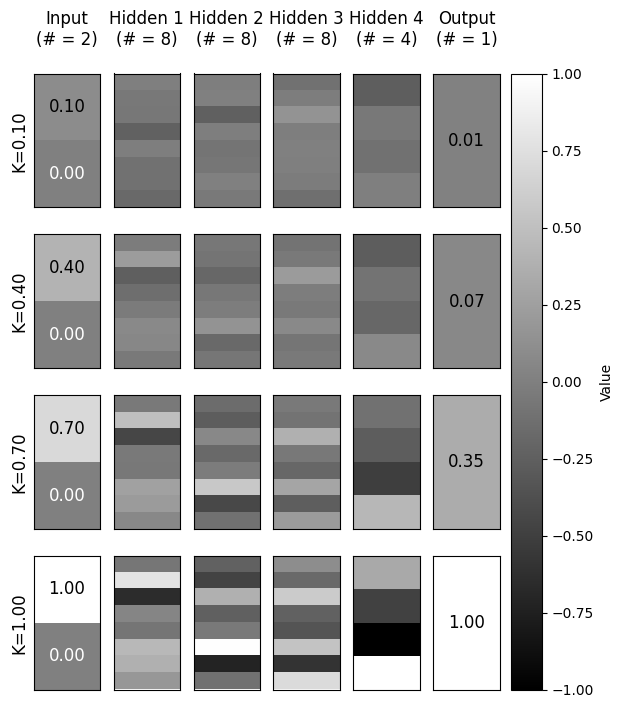

In [ ]:
plot_feature_path(
    model, X_batch=X_K,
    caption=f"Mean of 11 trials on {note.y3}",
    folder=f'latent_feature', filename='origin', other_val=0
) # Original Model(K^3) does not react to L var

0
11 6


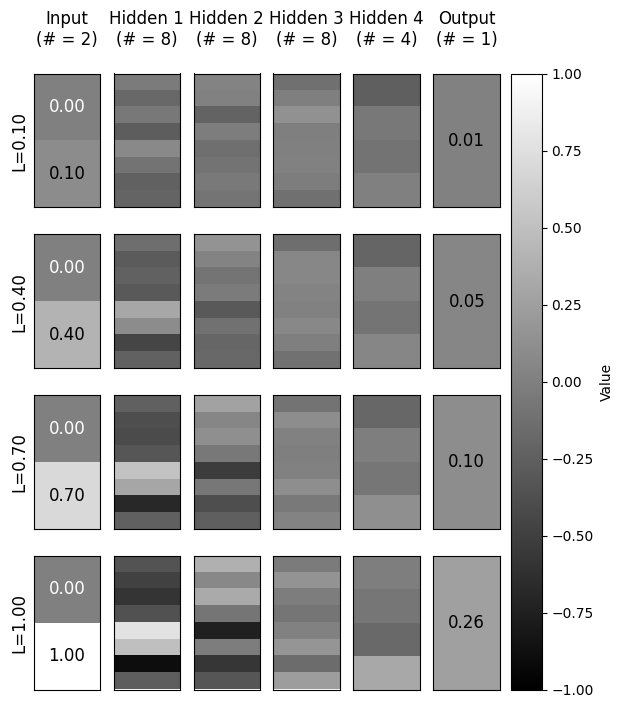

In [ ]:
plot_feature_path(
    model, X_batch=X_K,
    caption=f"Mean of 11 trials on {note.y3}", switchKL=True,
    folder=f'latent_feature', filename='origin', other_val=0
) # Original Model(K^3) does not react to L var

#### 4-2-2 Transfer Learning on Inverted K-Intensive

0
11 6


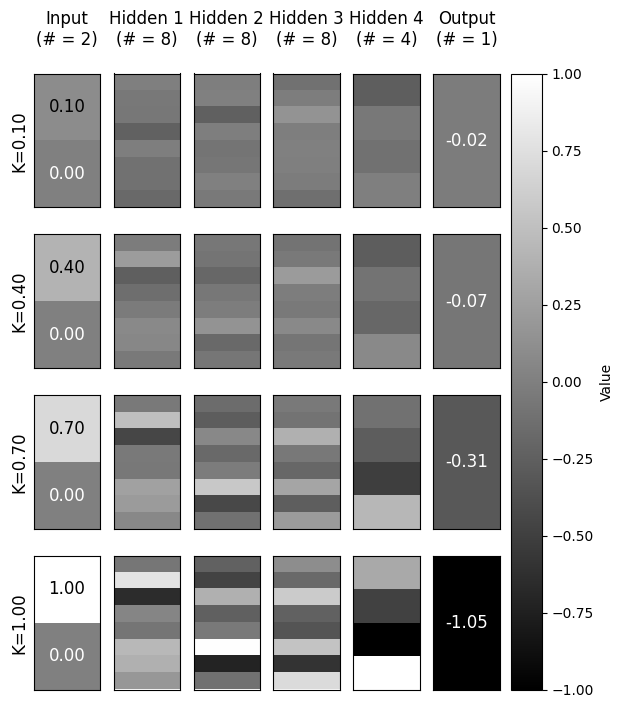

In [ ]:
plot_feature_path(
    model_tf_1layer_y2, X_batch=X_K,
    folder='latent_feature',  other_val=0,
    filename=f'transferlearn_{note.y2}')

0
11 6


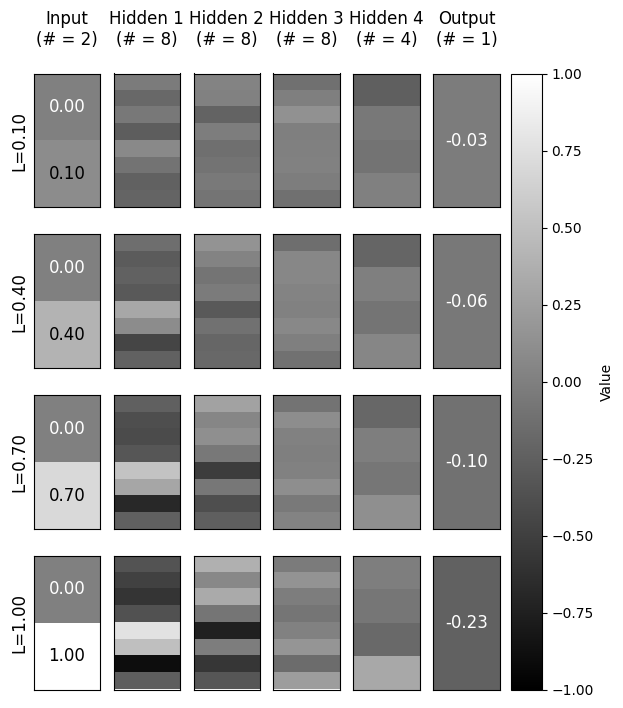

In [ ]:
plot_feature_path(
    model_tf_1layer_y2, X_batch=X_K, switchKL=True,
    folder='latent_feature',  other_val=0,
    filename=f'transferlearn_{note.y2}')

0
11 6


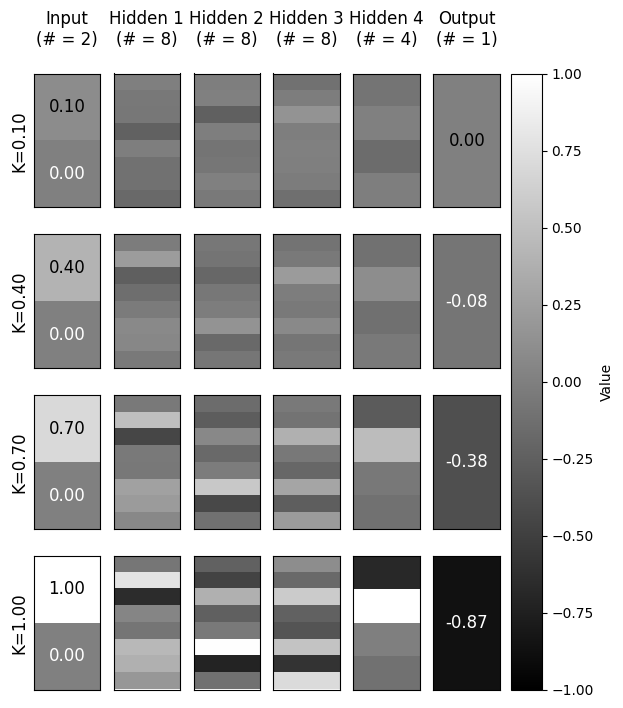

In [ ]:
plot_feature_path(
    model_tf_2layer_y2, X_batch=X_K,
    folder='latent_feature',  other_val=0,
    filename=f'transferlearn_{note.y2}__2lyr')

0
11 6


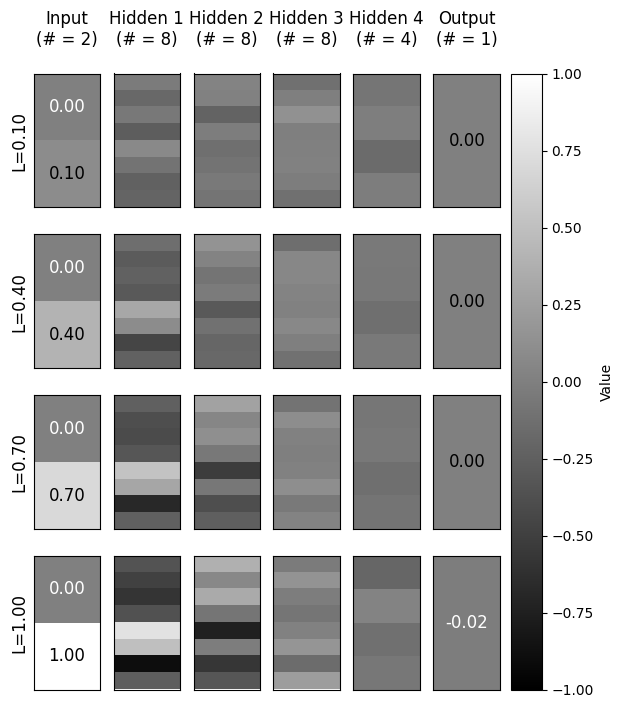

In [19]:
plot_feature_path(
    model_tf_2layer_y2, X_batch=X_L, switchKL=True,
    folder='latent_feature',  other_val=0,
    filename=f'transferlearn_{note.y2}__2lyr_unknown')

#### 4-2-3 Transfer Learning on L-Intensive

0
11 6


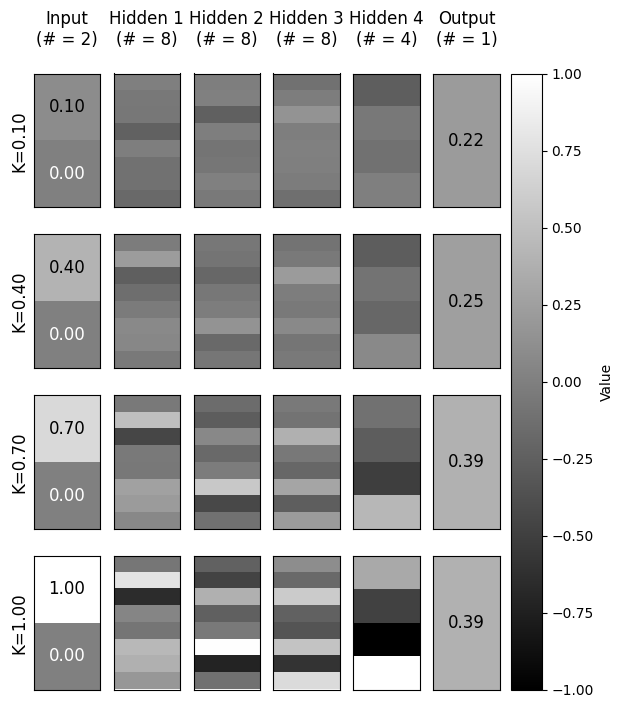

In [ ]:
plot_feature_path(model_tf_1layer_y3, X_batch=X_K,
      folder='latent_feature', other_val=0, switchKL=False,
    filename=f'transferlearn_{note.y3}')

0
11 6


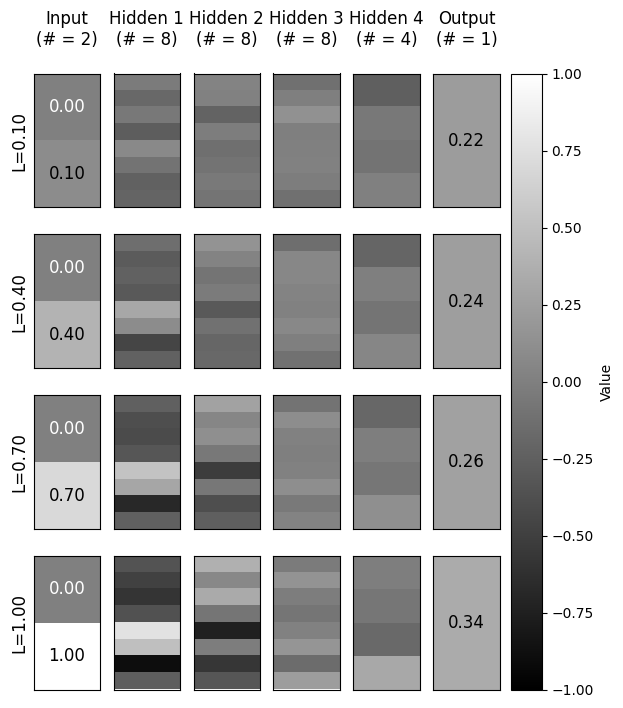

In [ ]:
plot_feature_path(model_tf_1layer_y3, X_batch=X_L,
      folder='latent_feature', other_val=0, switchKL=True,
    filename=f'transferlearn_{note.y3}')

0
11 6


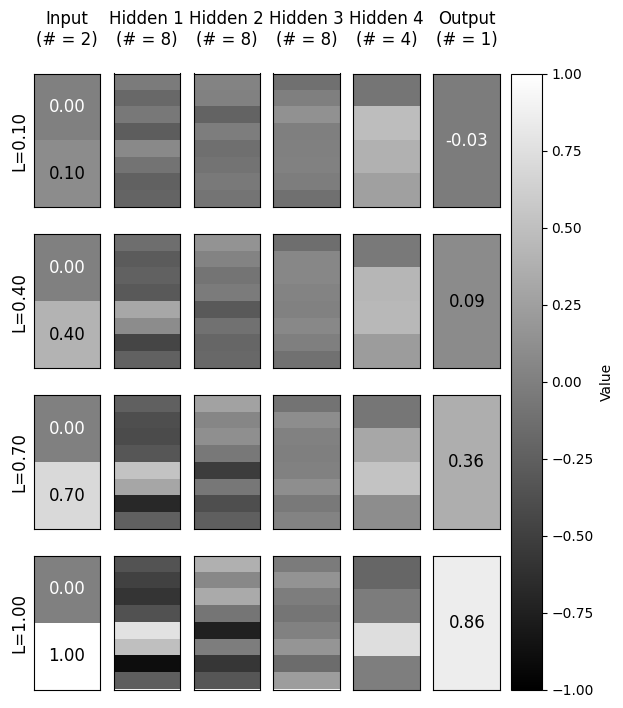

In [21]:
plot_feature_path(
    model_tf_2layer_y3, X_batch=X_L, switchKL=True,
    folder='latent_feature',  other_val=0,
    filename=f'transferlearn_{note.y3}__2lyr')

0
11 6


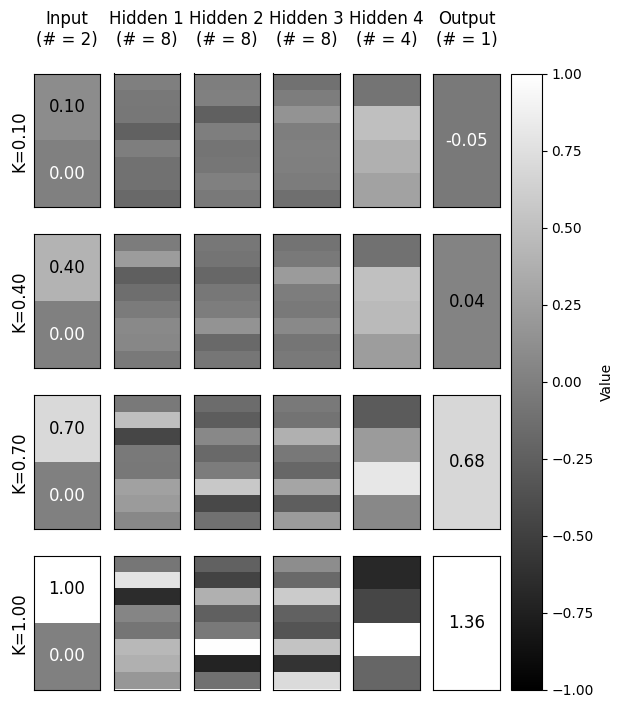

In [22]:
plot_feature_path(
    model_tf_2layer_y3, X_batch=X_K, switchKL=False,
    folder='latent_feature',  other_val=0,
    filename=f'transferlearn_{note.y3}__2lyr_unknown')

L=0.5

0.5
11 6
0.5
11 6
0.5
11 6


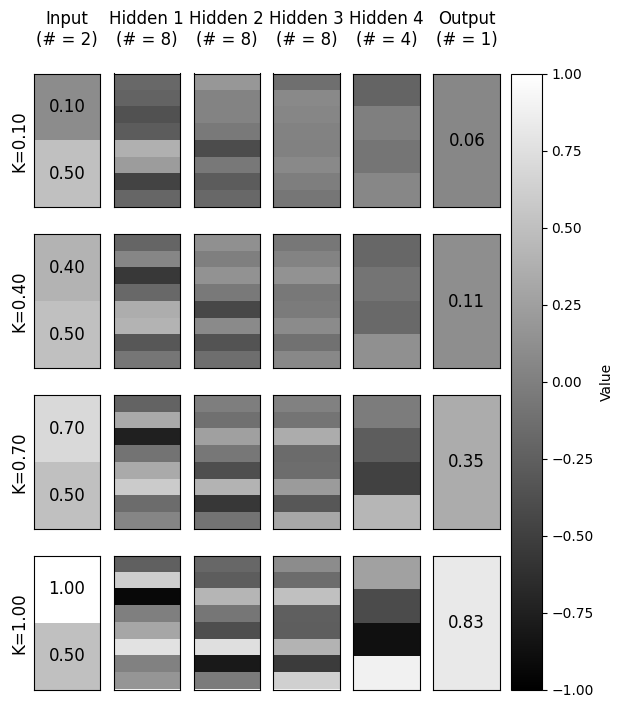

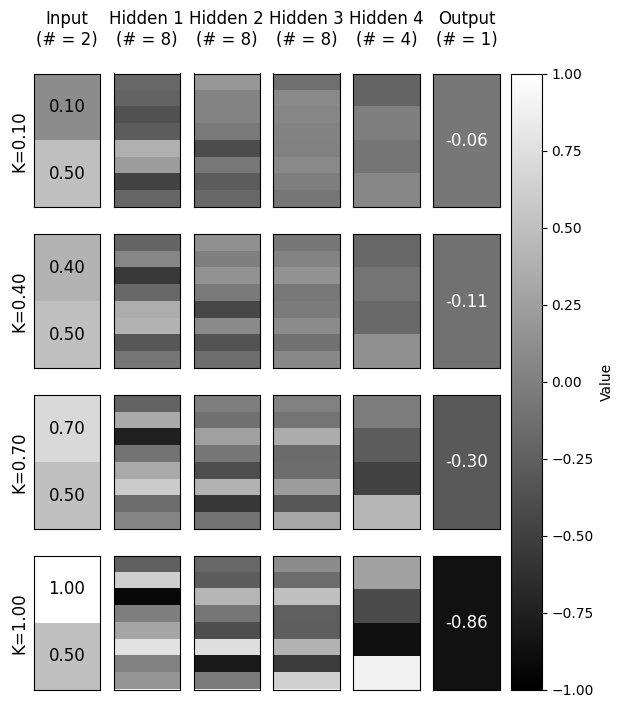

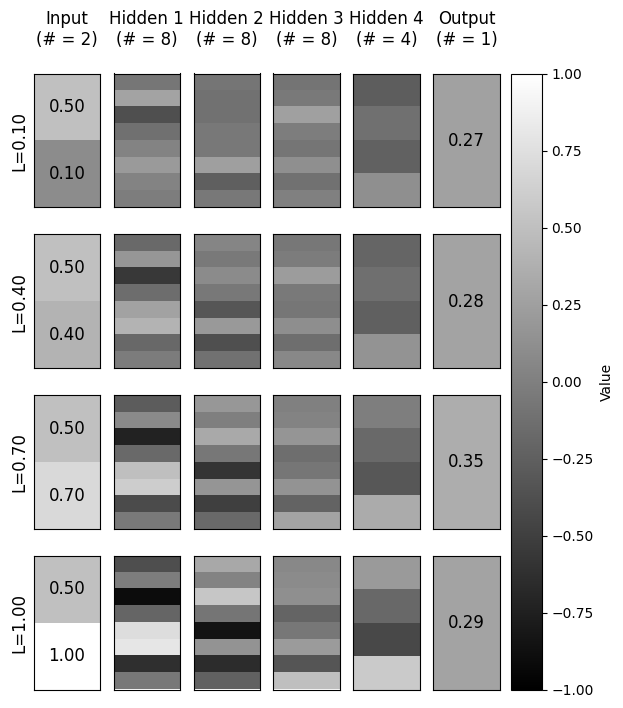

In [ ]:
plot_feature_path(
    model, X_batch=X_K,
    caption=f"Mean of 11 trials on {note.y3}",
    folder=f'latent_feature', filename='origin', other_val=0.5
) # Original Model(K^3) does not react to L var

plot_feature_path(
    model_tf_1layer_y2, X_batch=X_K,
    folder='latent_feature',  other_val=0.5,
    filename=f'transferlearn_{note.y2}')

plot_feature_path(model_tf_1layer_y3, X_batch=X_L,
      folder='latent_feature', other_val=0.5, switchKL=True,
    filename=f'transferlearn_{note.y3}')

L=1

1
11 6
1
11 6
1
11 6


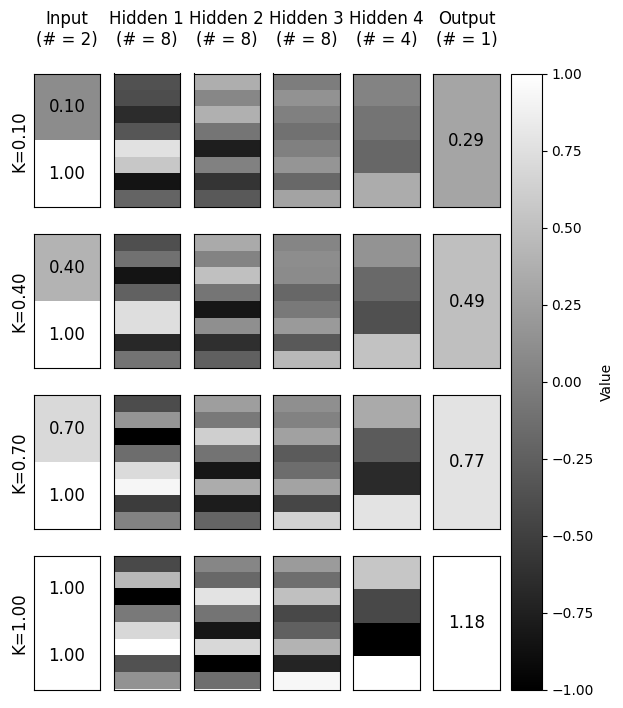

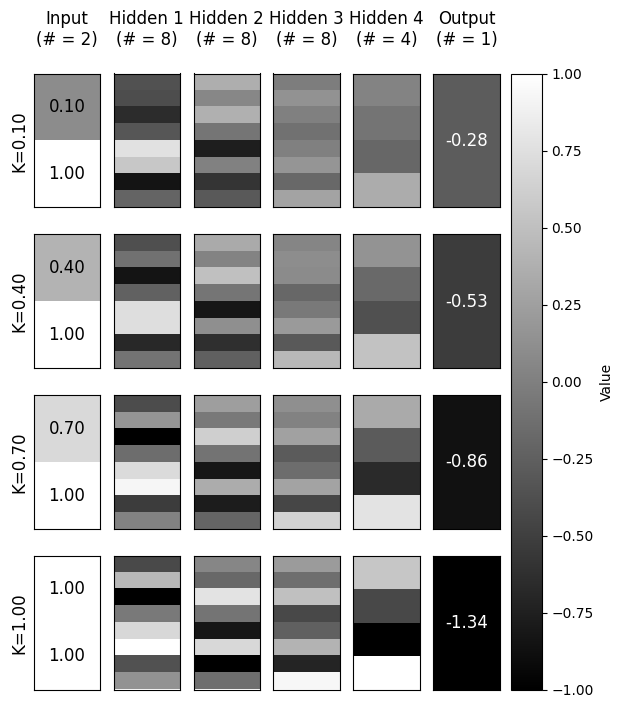

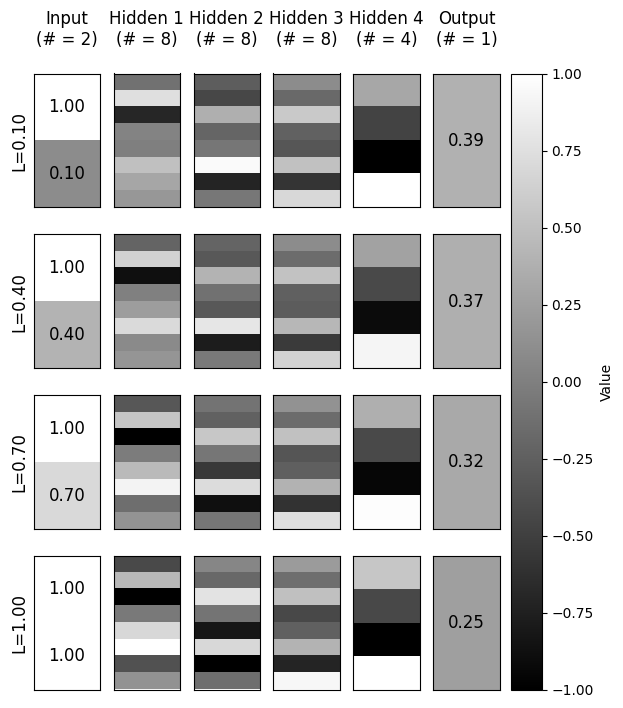

In [ ]:
plot_feature_path(
    model, X_batch=X_K,
    caption=f"Mean of 11 trials on {note.y3}",
    folder=f'latent_feature', filename='origin', other_val=1
) # Original Model(K^3) does not react to L var

plot_feature_path(
    model_tf_1layer_y2, X_batch=X_K,
    folder='latent_feature',  other_val=1,
    filename=f'transferlearn_{note.y2}')

plot_feature_path(model_tf_1layer_y3, X_batch=X_L,
      folder='latent_feature', other_val=1, switchKL=True,
    filename=f'transferlearn_{note.y3}')

# 5. Ten trials for Unknown Parameter

Show 10 Trials and Mean (model trained on K-intensive predicting L-intensive data)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

n_trials = 10

L_true_1d = y3.ravel()
K0_1d = K0.ravel()
L_1d  = L.ravel()

In [ ]:
# ---------- Compact Version: Base & Transfer Learning ----------

def run_trials(n_trials, train_X, train_y, eval_X, eval_y, epochs, note_label, fig_no, tl_model=None, filename='ten'):
    preds, mses = [], []

    for t in range(n_trials):
        print(f"[Trial {t+1}/{n_trials}] training on {note_label} ...")
        m = build_model(fixed=False) if tl_model is None else tl_model()

        m.fit(train_X, train_y, epochs=epochs, batch_size=32, verbose=0)
        pred = m.predict(eval_X, verbose=0).ravel()
        preds.append(pred)

        mse_t = mean_squared_error(eval_y.ravel(), pred)
        mses.append(mse_t)
        del m
        print(f"[Trial {t+1}/{n_trials}] MSE = {mse_t:.6f}")

    preds_raw = preds.copy()
    preds = np.vstack(preds)
    pred_mean = preds.mean(axis=0)
    mse_mean = mean_squared_error(eval_y.ravel(), pred_mean)
    print(f"\nMean MSE over {n_trials} trials ({note_label}): {mse_mean:.6f}")
    os.makedirs(f'{outdir}/ten_trial_unknown_param', exist_ok=True)

    draw_triptych(
        title_prefix=f"[{note_label} → {note.y3}]",
        Kv=K0_1d, Lv=L_1d, y_true=eval_y.ravel(), y_pred=pred_mean,
        fig_no=fig_no, y_lim=(-0.1, 1.1),
        caption=f" Mean of {n_trials} trials",
        folder=f'ten_trial_unknown_param/{filename}',

    )
    for t in range(n_trials):
        plt.scatter(eval_y, preds_raw[t], color="gray", alpha=0.2, s=5)

    if SHOW_CAPTION:
      plt.title(f"Overlay of all {n_trials} trials\n", fontdict={'fontsize': 14})
    plt.xlabel("L"); plt.ylabel("Ŷ"); plt.grid(); plt.show();
    if SAVE_SPLIT:
      _savefig(f"{outdir}/ten_trial_unknown_param/{filename}/overlay.png")


### 5-1. Original Model

[Trial 1/10] training on K-Intensive ...
[Trial 1/10] MSE = 0.067165
[Trial 2/10] training on K-Intensive ...
[Trial 2/10] MSE = 0.541799
[Trial 3/10] training on K-Intensive ...
[Trial 3/10] MSE = 0.003817
[Trial 4/10] training on K-Intensive ...
[Trial 4/10] MSE = 0.041886
[Trial 5/10] training on K-Intensive ...
[Trial 5/10] MSE = 0.056734
[Trial 6/10] training on K-Intensive ...
[Trial 6/10] MSE = 0.146956
[Trial 7/10] training on K-Intensive ...
[Trial 7/10] MSE = 0.515571
[Trial 8/10] training on K-Intensive ...
[Trial 8/10] MSE = 0.131778
[Trial 9/10] training on K-Intensive ...
[Trial 9/10] MSE = 0.147841
[Trial 10/10] training on K-Intensive ...
[Trial 10/10] MSE = 0.105560

Mean MSE over 10 trials (K-Intensive): 0.121379


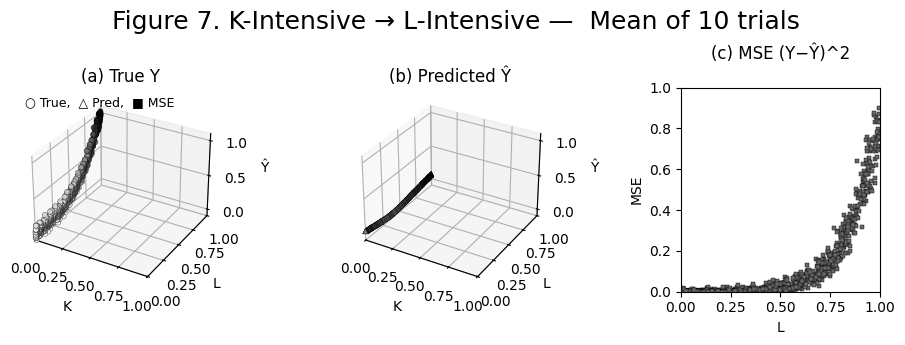

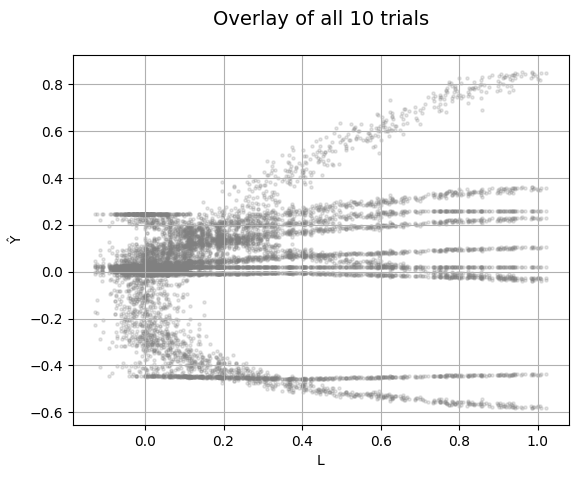

<Figure size 640x480 with 0 Axes>

In [ ]:
# ---------- (1) Base model: train y1 → test y3 ----------
run_trials(
    n_trials=n_trials,
    train_X=X_K, train_y=y1, eval_X=X_L, eval_y=y3,
    epochs=org_ep, note_label=note.y1,
    fig_no=3, filename='origin'
)

### 5-2. Transfer Learning on L-Intensive

[Trial 1/10] training on K-Intensive + L-Intensive ...
[Trial 1/10] MSE = 0.020144
[Trial 2/10] training on K-Intensive + L-Intensive ...
[Trial 2/10] MSE = 0.020642
[Trial 3/10] training on K-Intensive + L-Intensive ...
[Trial 3/10] MSE = 0.062232
[Trial 4/10] training on K-Intensive + L-Intensive ...
[Trial 4/10] MSE = 0.040395
[Trial 5/10] training on K-Intensive + L-Intensive ...
[Trial 5/10] MSE = 0.018918
[Trial 6/10] training on K-Intensive + L-Intensive ...
[Trial 6/10] MSE = 0.071622
[Trial 7/10] training on K-Intensive + L-Intensive ...
[Trial 7/10] MSE = 0.037746
[Trial 8/10] training on K-Intensive + L-Intensive ...
[Trial 8/10] MSE = 0.048811
[Trial 9/10] training on K-Intensive + L-Intensive ...
[Trial 9/10] MSE = 0.072498
[Trial 10/10] training on K-Intensive + L-Intensive ...
[Trial 10/10] MSE = 0.079900

Mean MSE over 10 trials (K-Intensive + L-Intensive): 0.044177


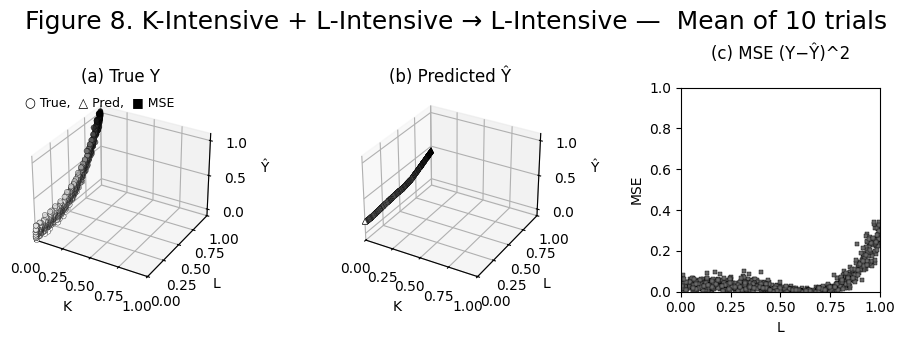

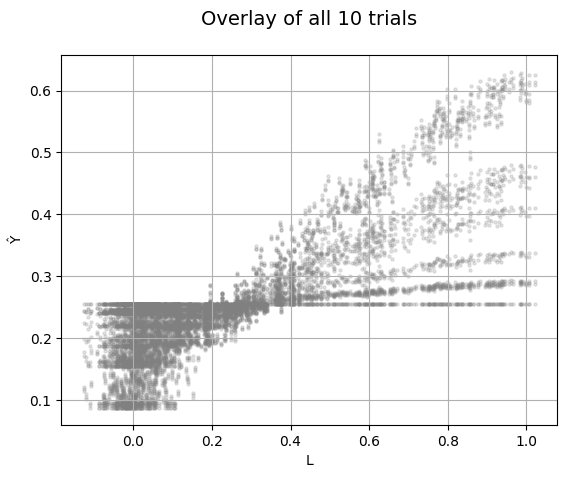

<Figure size 640x480 with 0 Axes>

In [ ]:
# ---------- (2) Transfer learning: freeze backbone + retrain head ----------
def build_tl_model():
    m_tl = Sequential(name="model_tf_1layer_y3")
    for lyr in model.layers[:-1]:
        lyr.trainable = False
        m_tl.add(lyr)
    m_tl.add(Dense(1, activation="linear", name="head_2layer_y3"))
    m_tl.compile(optimizer="adam", loss="mse")
    return m_tl

run_trials(
    n_trials=n_trials,
    train_X=X_L, train_y=y3, eval_X=X_L, eval_y=y3,
    epochs=tl_ep, note_label=f"{note.y1} + {note.y3}",
    fig_no=8, tl_model=build_tl_model,
    filename='transferlearn'
)


# [Skip] Weight Matrix

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import clone_model

# ---------- helpers ----------

def clone_architecture_like(m):
    """Clone architecture only, then build with the same input shape."""
    mc = clone_model(m)
    # build by calling once (assumes input shape (2,))
    _ = mc(tf.zeros((1, 2)))
    return mc

def layer_weight_slices(model):
    """
    Map each layer to the flat weight indices in model.get_weights().
    Returns: list of tuples (layer_name, start, end) covering all weights.
    """
    slices = []
    idx = 0
    for lyr in model.layers:
        n = len(lyr.get_weights())
        if n > 0:
            slices.append((lyr.name, idx, idx + n))
            idx += n
    return slices  # order matches model.get_weights()

def make_grid(nk=60, nl=60):
    K = np.linspace(0, 1, nk)
    L = np.linspace(0, 1, nl)
    KK, LL = np.meshgrid(K, L, indexing="xy")
    Xg = np.stack([KK.ravel(), LL.ravel()], axis=1).astype(np.float32)
    return KK, LL, Xg


In [ ]:
def _plot_scatter(ax, x, y, z):
    ax.scatter(x, y, z, c=z, cmap='gray', s=20, vmin=-0.75, vmax=0.75)


def _plot_axes_label(ax, xlabel: str, ylabel: str, zlabel: str):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.grid(True)


def plot_weights_3d(layers, subtitle:str=''):
    num_layers = len(layers)
    fig = plt.figure(figsize=(4*num_layers, 6))
    fig.suptitle(f"[{subtitle}] Original Model - Transfer Learning", fontsize=16)

    for i, layer in enumerate(layers):
        w, _ = layer.get_weights()
        ax = fig.add_subplot(1, num_layers, i+1, projection='3d')
        X_vals, Y_vals = np.meshgrid(np.arange(w.shape[0]), np.arange(w.shape[1]))
        Z_vals = w.flatten()
        _plot_scatter(ax, X_vals.flatten(), Y_vals.flatten(), Z_vals)
        ax.set_zlim(-0.75, 0.75)
        _plot_axes_label(ax, 'Input Neuron', 'Output Neuron', 'Weight Value')
        ax.set_title(f"Layer {i+2}\n" + \
            f"X:({X_vals.shape})\nY:({Y_vals.shape})\nZ:({w.shape})")
    plt.show()
    plt.close()


def visualize_difference_weight_matrix(model_src, model_tgt, zlim=None):
    """
    Interpolate ONLY the last trainable layer's weights between model_src and model_tgt.

    Assumptions:
      - model_src and model_tgt share the same architecture.
      - The only difference between them is the last layer's weights
        (backbone already frozen and identical).

    lambdas : iterable of λ in [0,1].
    """
    # 1) sanity check: same architecture
    w_src = model_src.get_weights()
    w_tgt = model_tgt.get_weights()
    assert len(w_src) == len(w_tgt), "Models must share architecture (same number of weights)."
    for a, b in zip(w_src, w_tgt):
        if a.shape != b.shape:
            raise ValueError("Weight shapes differ; ensure identical architectures.")

    # 2) find the last trainable layer slice (usually the final Dense(1))
    slices = layer_weight_slices(model_src)
    last_layer_name, start, end = slices[-1]   # last layer with weights
    print(f"Interpolating last layer only: {last_layer_name}, weights indices [{start}:{end})")

    # 3) prepare grid and fixed endpoints
    KK, LL, Xg = make_grid()
    m_mid = clone_architecture_like(model_src)
    w_mid = list(w_src)
    for i in range(1, len(nodes)+1):
      m_mid.layers[i].set_weights([
          model_src.layers[i].get_weights()[0]-model_tgt.layers[i].get_weights()[0],
          model_src.layers[i].get_weights()[1]-model_tgt.layers[i].get_weights()[1],
          ])
    title = f"Last-layer Weight Difference"

    plot_weights_3d(m_mid.layers[:], subtitle='Difference of Weight Matrices')




Interpolating last layer only: dense_65, weights indices [8:10)


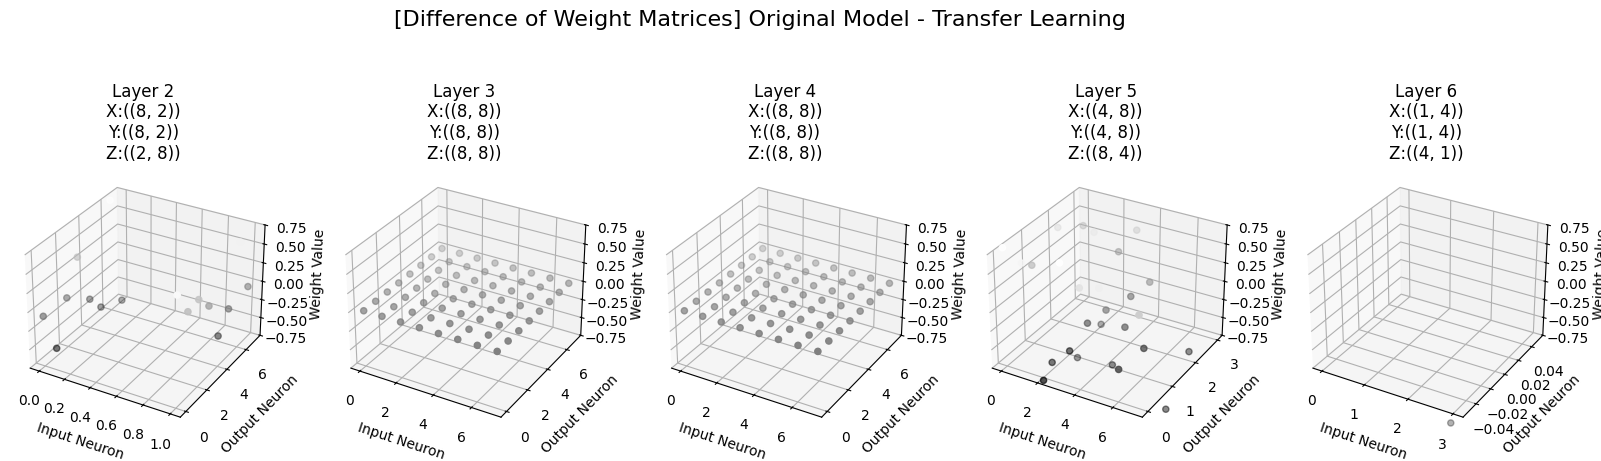

Interpolating last layer only: dense_65, weights indices [8:10)


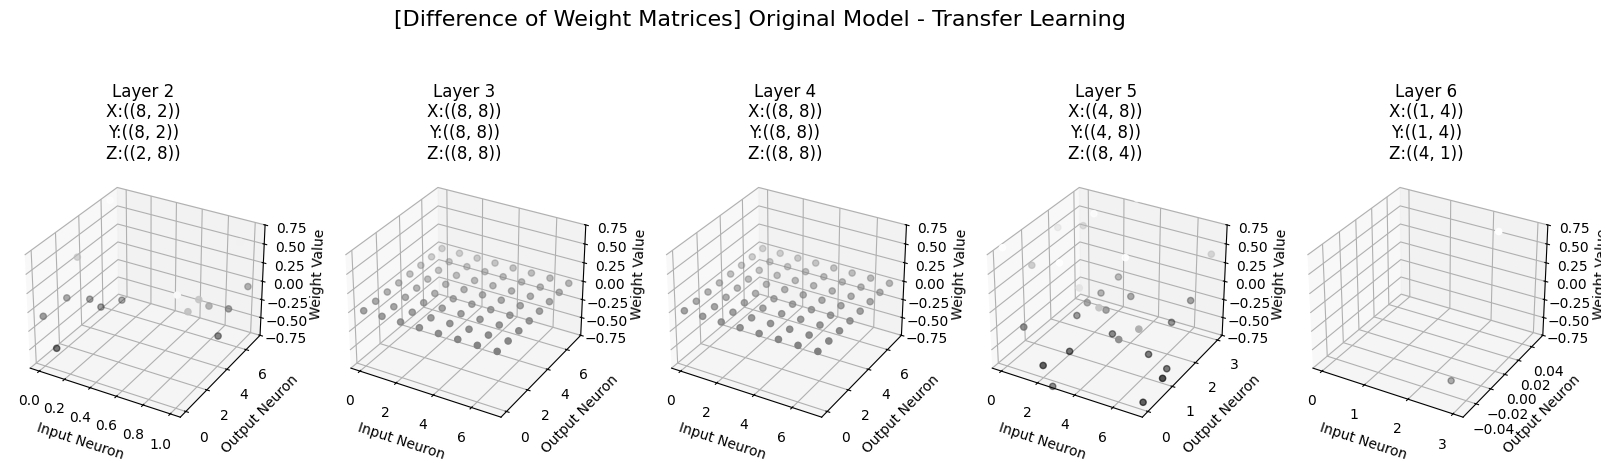

In [ ]:
visualize_difference_weight_matrix(
    model_src=model,
    model_tgt=model_tf_2layer_y3,
)

visualize_difference_weight_matrix(
    model_src=model,
    model_tgt=model_tf_2layer_y2,
)
